# Top2vec

Explore a top2vec model based on data.gouv.fr's catalog.

## Model training instructions

**warning** `learn_top2vec.py` needs a python 3.10 env to run (some libraries not compatible with python > 3.10 ATM).

You need to install [qsv](https://qsv.dathere.com) in order to preprocess the CSV catalog file.

```shell
pip install top2vec[sentence_transformers]
# download the latest catalog
make download
# create a cleaned version of the catalog
make filter
# train the model
python learn_top2vec.py train-model
```

In [185]:
from top2vec import Top2Vec

In [186]:
embedding_model = "distiluse-base-multilingual-cased"
model_file = f"top2vec_{embedding_model}.bin"
model = Top2Vec.load(model_file)

In [187]:
model.get_num_topics()

603

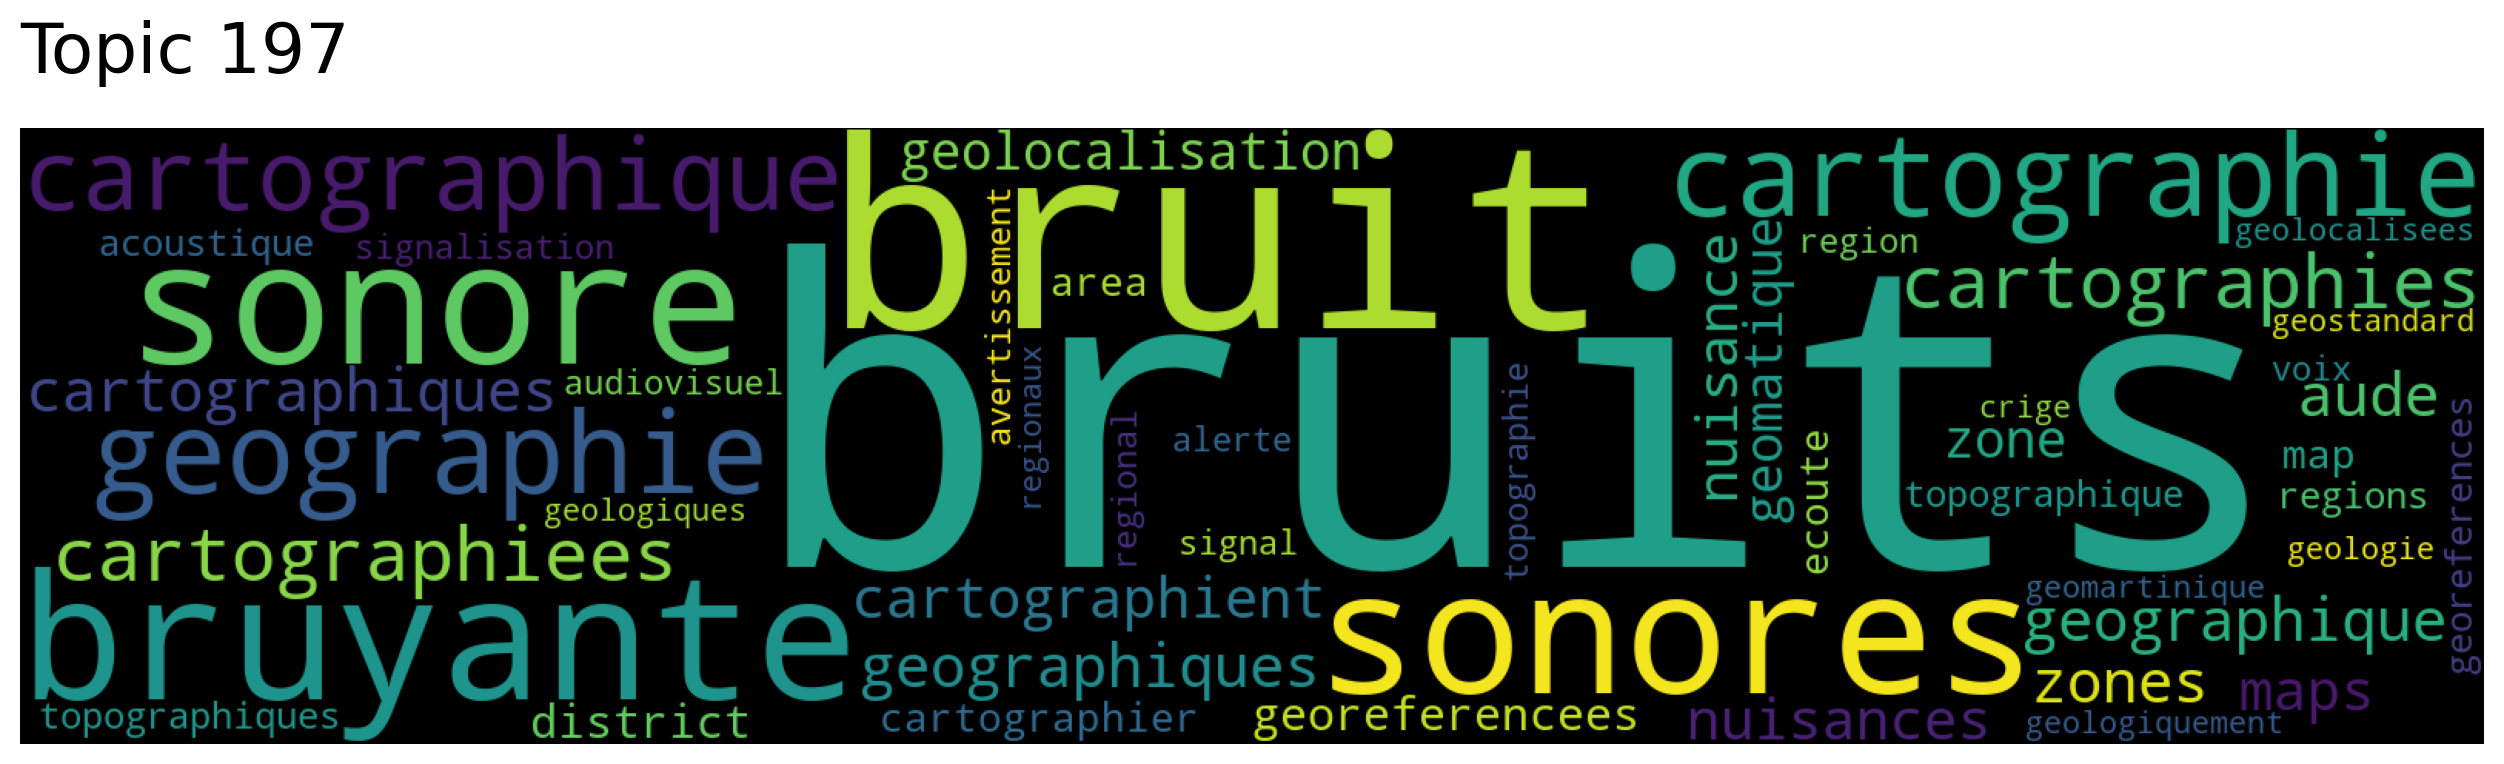

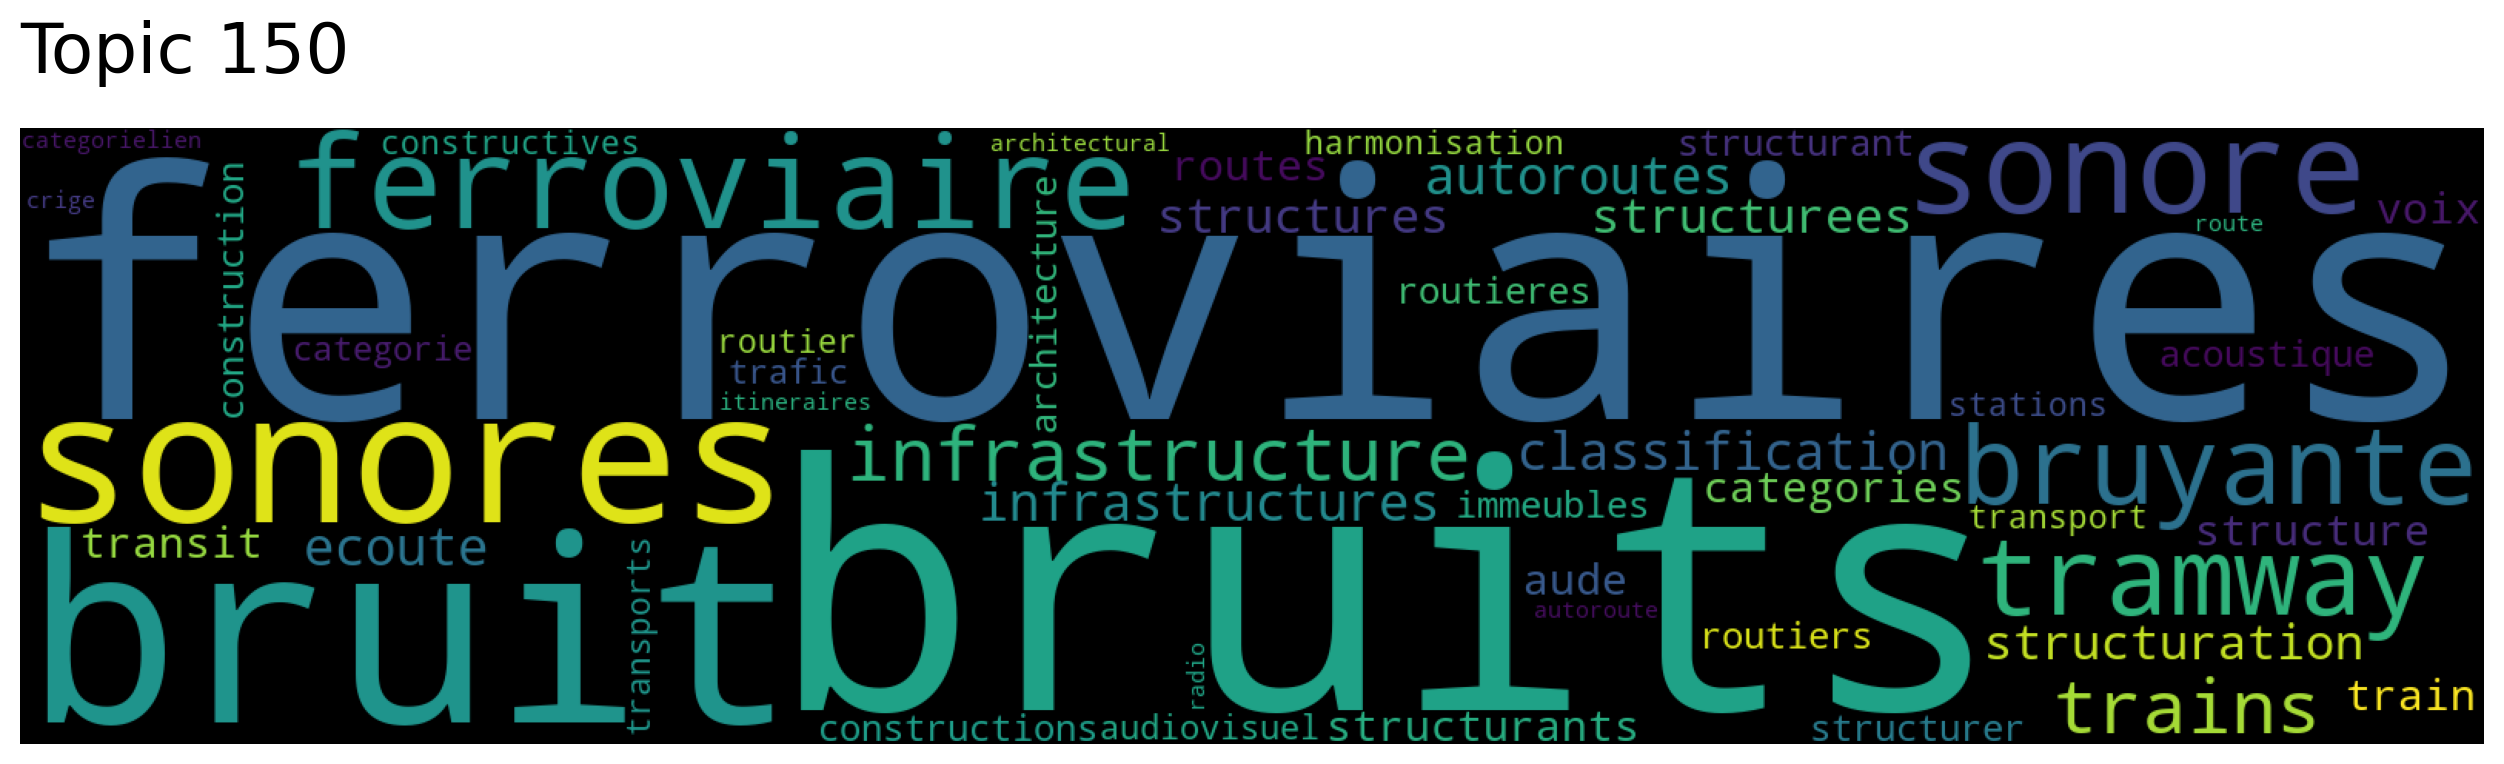

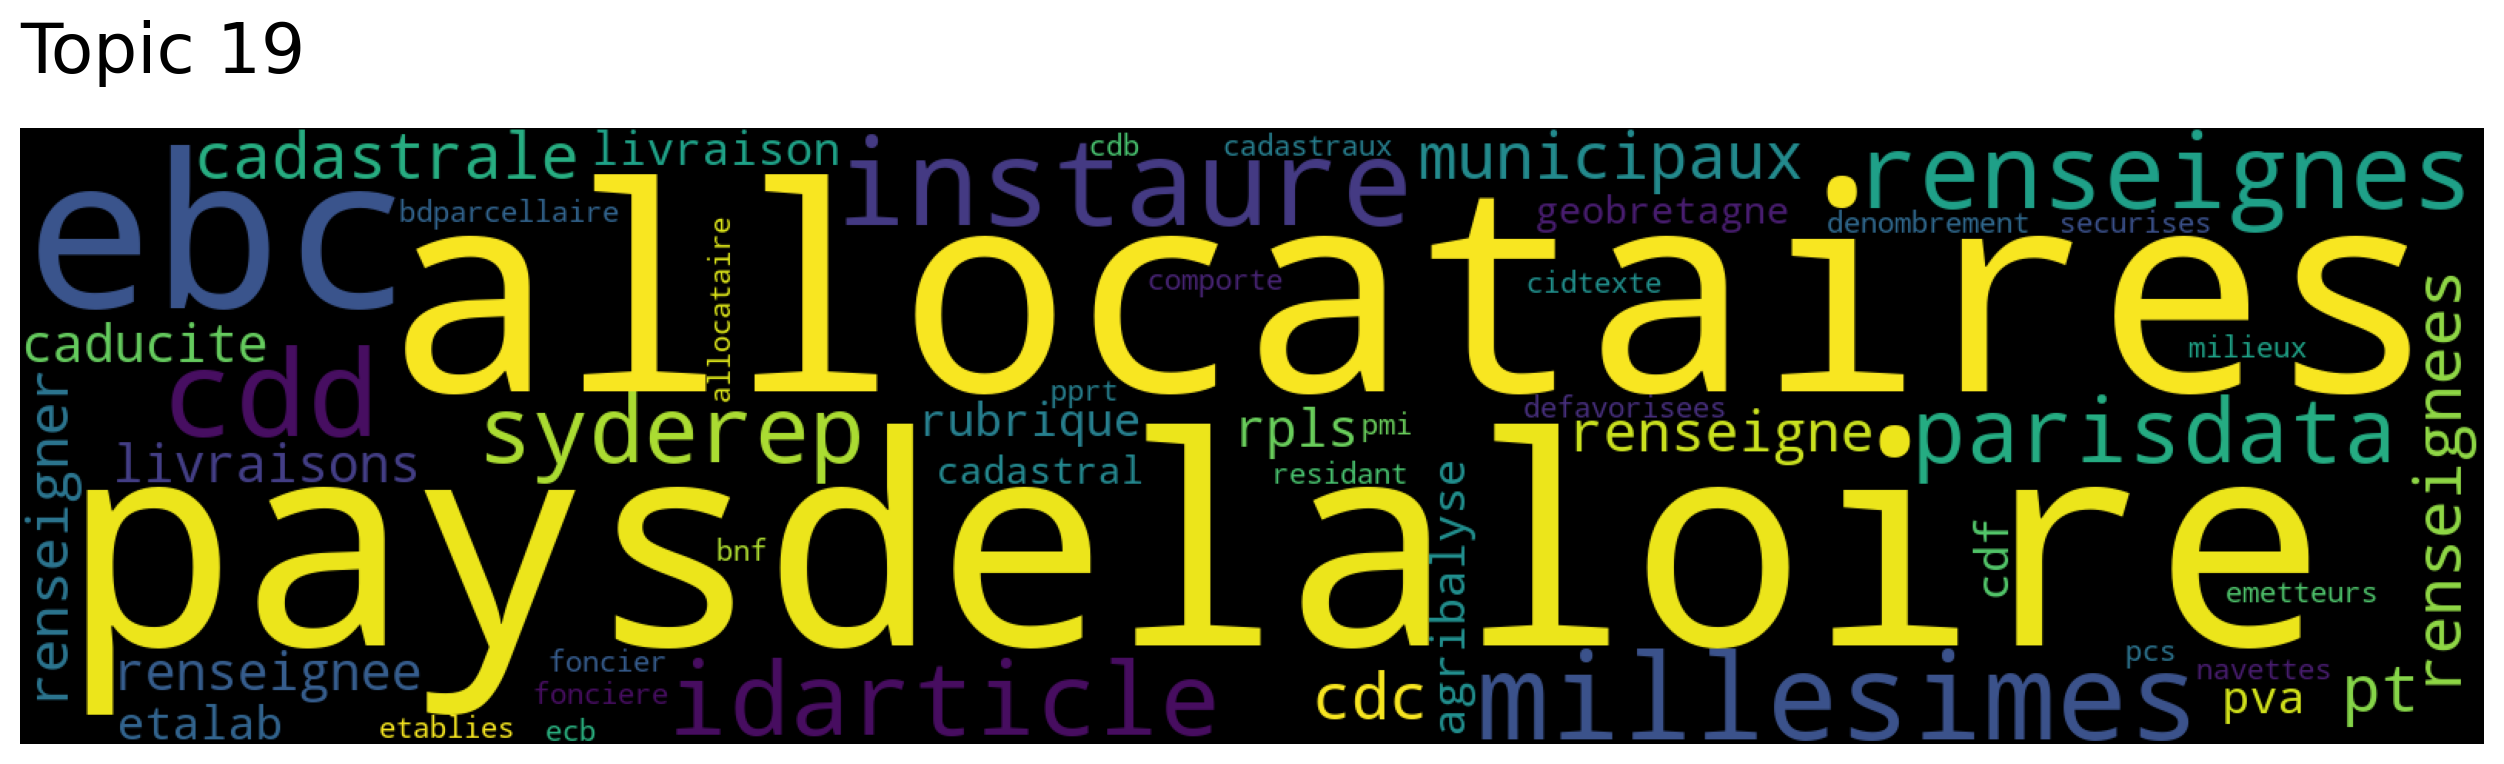

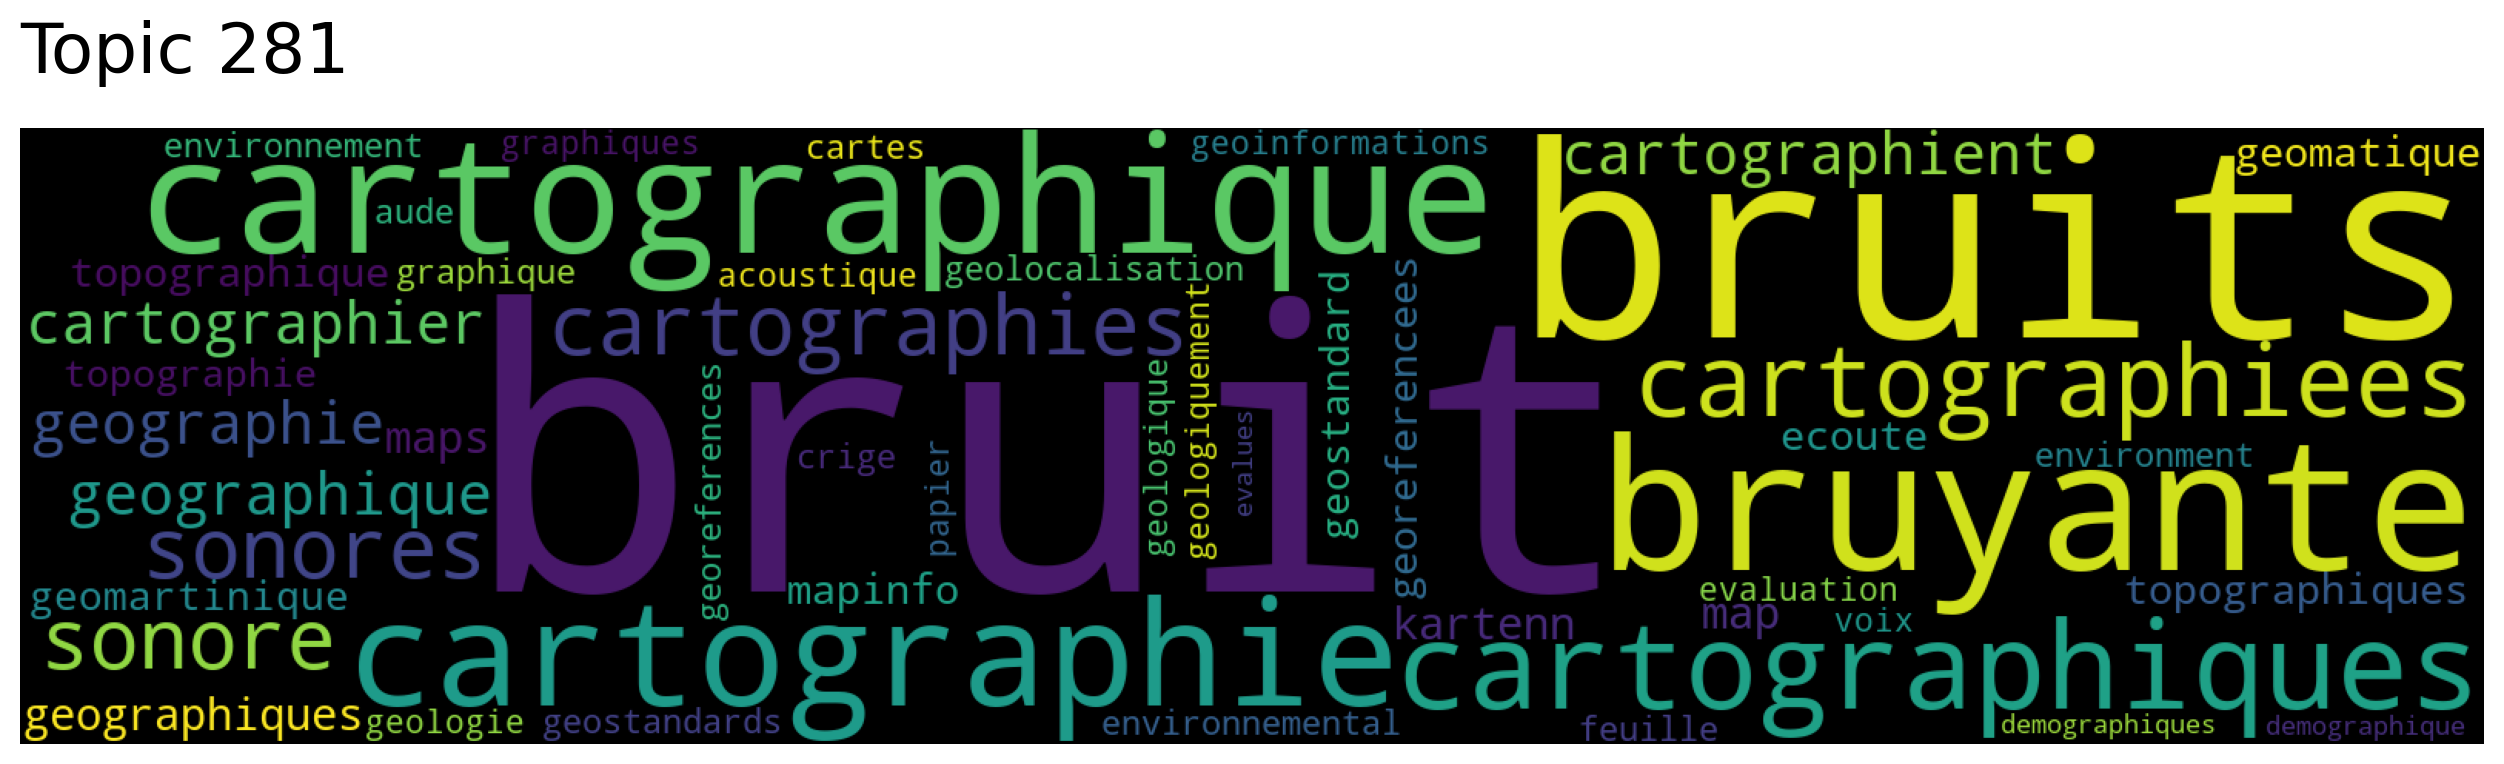

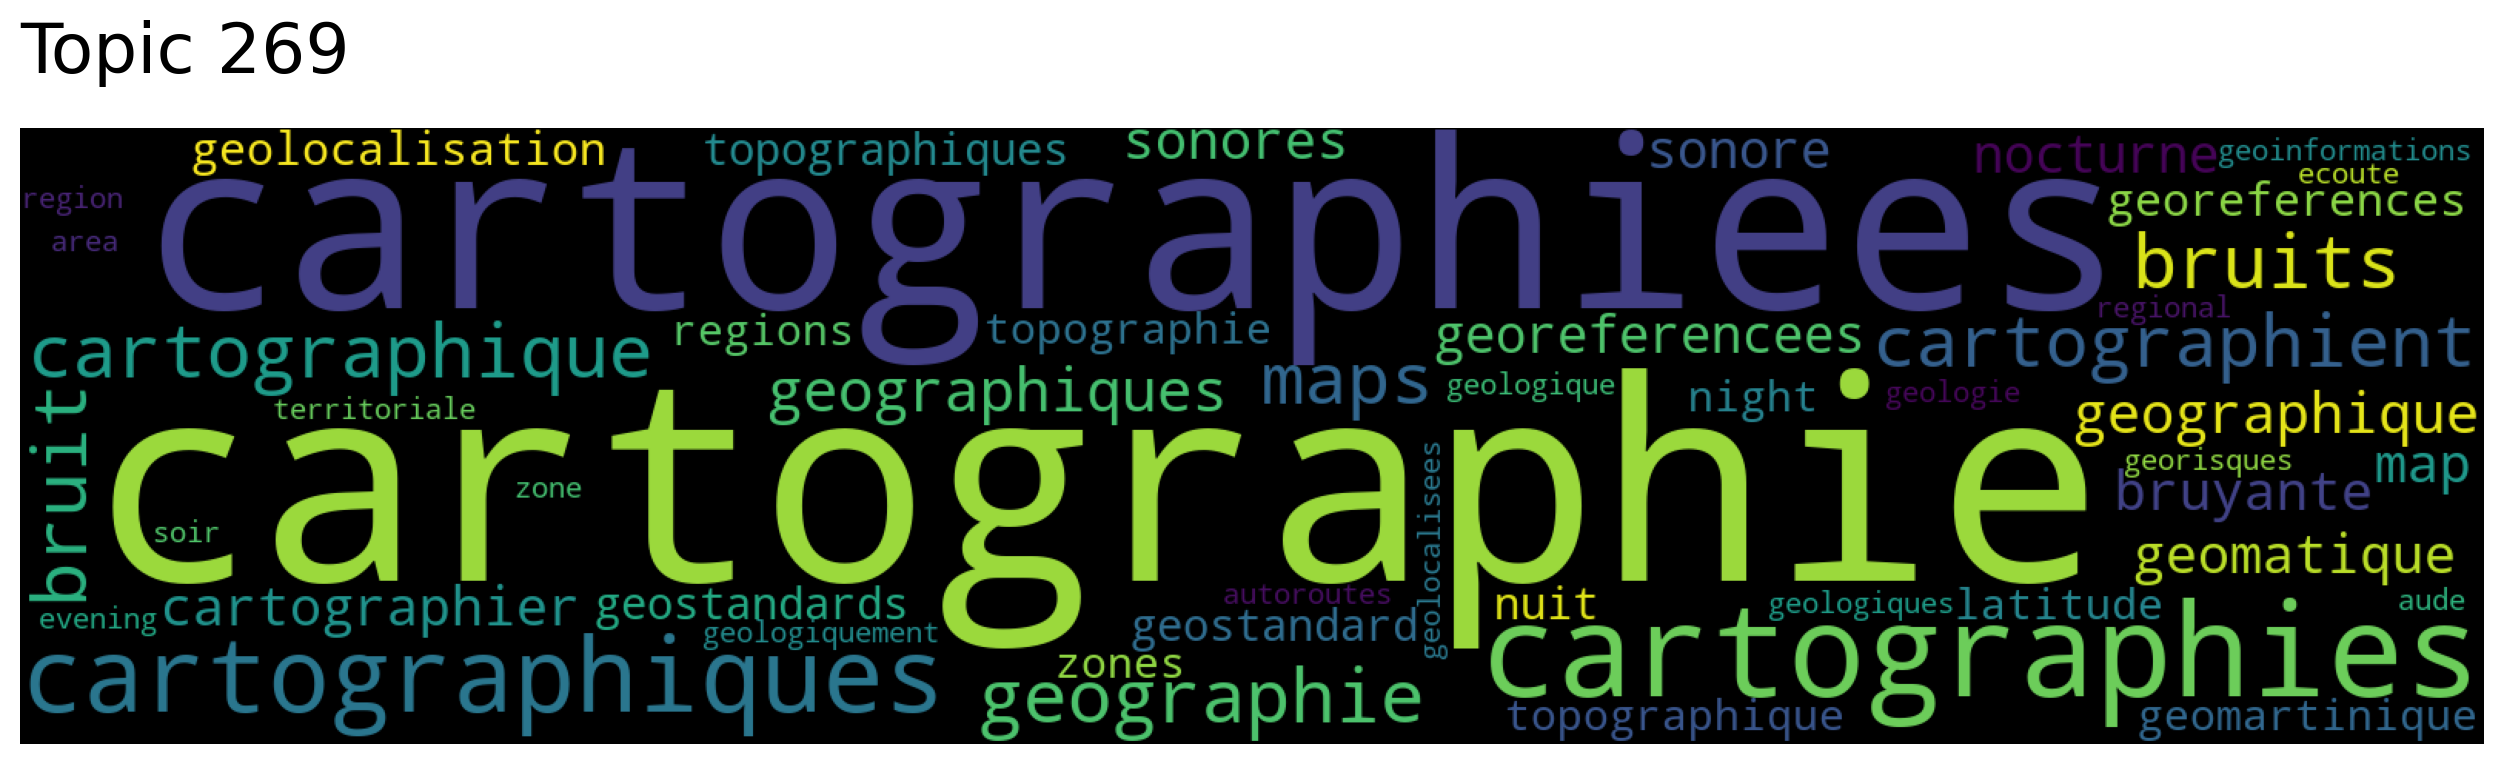

In [188]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["bruit"], num_topics=5)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

## Use keywords.yml for search_topics

Tokenize keywords.yml for every theme and apply search_topics for keywords that are in the vector space.

Get a list of interesting topics for every theme, filter them by common topics (too common, not precise enough) and manuel pruning. Use the first one as the most interesting.

Export a list of documents for every prefered topic for every theme.

In [189]:
from top2vec.Top2Vec import default_tokenizer

In [190]:
from utils import load_raw_keywords, load_kw_file

In [191]:
tokenized_tags = {}
for theme, tags in load_kw_file().items():
    tokenized_tags[theme] = [default_tokenizer(t) for t in tags]
tokenized_tags

{'Gestion des eaux': [['eau'], ['stress', 'hydrique'], ['trame', 'bleue']],
 'Qualité des sols': [['sol'], ['poussiere'], ['sediment']],
 'Aménagement et occupation du sol': [['sol'],
  ['occupation'],
  ['usage'],
  ['amiante']],
 'Champs électromagnétiques': [['rayonnements', 'ionisants'],
  ['rayonnements', 'non', 'ionisants'],
  ['rayonnements', 'optiques'],
  ['nanoparticules', 'de', 'carbone'],
  ['champs']],
 "Qualité de l'air": [['air'], ['monoxyde', 'de', 'carbone']],
 'Environnement sonore': [['bruit'],
  ['nuisance', 'sonore'],
  ['ambiance', 'thermique'],
  ['vibration']],
 'Luminosité': [['eclairage', 'public']],
 'Température': [['canicule'],
  ['ilot', 'de', 'chaleur'],
  ['ilot', 'de', 'fraicheur'],
  ['temperature']],
 'Risques alimentaires': [['aliment'], ['conservateur']],
 'Biodiversité': [['faune'],
  ['flore'],
  ['vegetal'],
  ['vegetaux'],
  ['insecte'],
  ['reservoir', 'biologique'],
  ['bacterie'],
  ['champignon', 'microscopique'],
  ['trame', 'verte'],
  ['v

In [192]:
def top_topics_for_theme(theme):
    tags = [t for sublist in tokenized_tags[theme] for t in sublist if t in model.vocab]
    if tags:
        topic_words, word_scores, topic_scores, topic_nums = model.search_topics(
            keywords=tags, num_topics=5
        )
    else:
        topic_nums = []
    return topic_nums

In [193]:
topics = {theme: top_topics_for_theme(theme) for theme in tokenized_tags.keys()}
topics

{'Gestion des eaux': array([ 19, 520, 459, 182, 236]),
 'Qualité des sols': array([ 19, 520, 459, 182, 475]),
 'Aménagement et occupation du sol': array([ 19, 520, 459, 182, 373]),
 'Champs électromagnétiques': array([ 19, 520, 459, 182, 373]),
 "Qualité de l'air": array([ 19, 520, 459, 182, 523]),
 'Environnement sonore': array([ 19, 197, 520, 459, 150]),
 'Luminosité': array([ 19, 349, 520, 459, 204]),
 'Température': array([ 19, 520, 459, 182, 373]),
 'Risques alimentaires': [],
 'Biodiversité': array([ 19, 520, 459, 182, 483]),
 'Autre': array([ 19, 520, 459, 182, 373])}

In [194]:
topics_lists = list(topics.values())
topics_intersection = set(topics_lists[0])
for array in topics_lists[1:]:
    if len(array):
        topics_intersection &= set(array)
topics_intersection = list(topics_intersection)
topics_intersection

[520, 19, 459]

In [195]:
def get_topic_words(topic_num):
    return model.topic_words[topic_num]

In [196]:
excluded_topics = [
    *topics_intersection,
    # uninteresting topic (description about description)
    182,
]

best_topic_for_themes = {}

for theme, theme_topics in topics.items():
    print(theme)
    unique_topics = [t for t in theme_topics if t not in excluded_topics]
    for t in unique_topics:
        print(t, get_topic_words(t))
    best_topic_for_themes[theme] = unique_topics[0] if unique_topics else None

best_topic_for_themes

Gestion des eaux
236 ['hydrographique' 'hydrographiques' 'hydrographie' 'hydrologiques'
 'hydrogeologique' 'eaux' 'aquatique' 'hydro' 'aquatiques' 'water' 'eau'
 'fontaines' 'fontaine' 'inondation' 'hydraulique' 'inondations'
 'hydrauliques' 'irrigation' 'eaufrance' 'piscines' 'inondables'
 'reservoir' 'basin' 'fluvial' 'geolocalisation' 'geomartinique'
 'reservoirs' 'piscine' 'geologie' 'geologique' 'geologiques' 'inondable'
 'geolocalisee' 'geologiquement' 'geomatique' 'geolocalisees'
 'geolocalises' 'humide' 'cartographique' 'geolocalise' 'geographie'
 'cartographie' 'cartographiques' 'cartographiees' 'bassin'
 'canalisations' 'fleuve' 'cartographies' 'cartographient' 'georisques']
Qualité des sols
475 ['geographie' 'geographique' 'geomatique' 'geographiques'
 'geolocalisation' 'geologique' 'topographie' 'geolocalisee' 'geologie'
 'topographiques' 'topographique' 'geolocalise' 'georisques' 'geologiques'
 'geologiquement' 'georeferencees' 'geomartinique' 'geolocalisees' 'geo'
 'geolo

{'Gestion des eaux': 236,
 'Qualité des sols': 475,
 'Aménagement et occupation du sol': None,
 'Champs électromagnétiques': None,
 "Qualité de l'air": 523,
 'Environnement sonore': 197,
 'Luminosité': 349,
 'Température': None,
 'Risques alimentaires': None,
 'Biodiversité': 483,
 'Autre': None}

In [149]:
import csv
from datetime import datetime
from pathlib import Path
from slugify import slugify

output_path = Path("output") / datetime.now().strftime('%Y%m%d-%H%M%S')
output_path.mkdir(exist_ok=True)

for theme, best_topic in best_topic_for_themes.items():
    if not best_topic:
        continue
    nb_docs = model.topic_sizes[best_topic]
    doc_scores, doc_ids = model.search_documents_by_topic(best_topic, nb_docs, return_documents=False)
    output_file = f"top2vec-search-output_{slugify(theme)}.csv"
    with (output_path / output_file).open("w") as f:
        writer = csv.DictWriter(f, fieldnames=["slug", "score"])
        writer.writeheader()
        writer.writerows([{
            "slug": item[0],
            "score": item[1],
        } for item in zip(doc_ids, doc_scores)])

## query_topics

Use query topics with queries generated from keywords.yml. Find the best topic(s) and export docs for it.

**How to normalize score across different topics?**

`score = topic_score_in_query * doc_score_in_topic`

In [170]:
# manually identified
excluded_topics = [19, 88, 182]
best_topics_for_themes = {}

for theme in load_kw_file().keys():
    query = theme
    # does not change results much
    # query = " ".join([theme, *load_raw_keywords(theme)])
    topics_words, word_scores, topic_scores, topic_nums = model.query_topics(theme, num_topics=5)
    best_topics_for_themes[theme] = [
        item for item in zip(topic_nums, topic_scores) if item[0] not in excluded_topics
    ]

best_topics_for_themes

{'Gestion des eaux': [(57, 0.47281092),
  (27, 0.46141285),
  (144, 0.44912094),
  (169, 0.44054484),
  (484, 0.39178547)],
 'Qualité des sols': [(119, 0.28323805), (567, 0.24830303), (183, 0.23547919)],
 'Aménagement et occupation du sol': [(119, 0.3063383),
  (462, 0.25073013),
  (535, 0.24603958)],
 'Champs électromagnétiques': [(191, 0.3507545),
  (444, 0.2715377),
  (373, 0.23775293)],
 "Qualité de l'air": [(109, 0.42713243), (374, 0.4135859), (162, 0.22424623)],
 'Environnement sonore': [(197, 0.34859622),
  (281, 0.34229377),
  (150, 0.32280058),
  (395, 0.29953033)],
 'Luminosité': [(349, 0.33916944), (520, 0.19095907), (459, 0.1659342)],
 'Température': [(459, 0.26830447), (520, 0.2171959), (141, 0.16834985)],
 'Risques alimentaires': [(520, 0.21521647),
  (459, 0.2105778),
  (155, 0.19377202),
  (249, 0.18158738)],
 'Biodiversité': [(522, 0.32118142),
  (137, 0.28638083),
  (48, 0.26129866),
  (319, 0.25030774)],
 'Autre': [(520, 0.250756), (459, 0.1968447), (373, 0.122879475

In [183]:
output_path = Path("output") / datetime.now().strftime('%Y%m%d-%H%M%S')
output_path.mkdir(exist_ok=True)

for theme, topics_with_score in best_topics_for_themes.items():
    print(theme)
    theme_docs_with_scores = []
    for topic_num, topic_score in topics_with_score:
        doc_scores, doc_ids = model.search_documents_by_topic(
            topic_num, model.topic_sizes[topic_num], return_documents=False
        )
        # account for topic match score to query * doc match score to topic
        normalized_score = doc_scores * topic_score
        theme_docs_with_scores += zip(doc_ids, normalized_score)
    # sort by normalized score after merge
    theme_docs_with_scores.sort(key=lambda x: x[1], reverse=True)
    # export to CSV
    output_file = f"top2vec-query-output_{slugify(theme)}.csv"
    with (output_path / output_file).open("w") as f:
        writer = csv.DictWriter(f, fieldnames=["slug", "score"])
        writer.writeheader()
        writer.writerows([{
            "slug": item[0],
            "score": item[1],
        } for item in theme_docs_with_scores])

Gestion des eaux
Qualité des sols
Aménagement et occupation du sol
Champs électromagnétiques
Qualité de l'air
Environnement sonore
Luminosité
Température
Risques alimentaires
Biodiversité
Autre
